## Imports

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

import gensim.downloader as gensim_api 

from tqdm import tqdm 
tqdm.pandas()
import gc

In [2]:
train_dset_df = pd.read_csv("2020_10_19_train_dset_df_nostem_nostoprem.csv")
test_dset_df = pd.read_csv("2020_10_19_test_dset_df_nostem_nostoprem.csv")

train_dset_df["preprocessed_joined"].fillna("", inplace=True)
test_dset_df["preprocessed_joined"].fillna("", inplace=True)

train_dset_y = train_dset_df["target"].to_numpy()
word2vec = gensim_api.load("word2vec-google-news-300")

In [3]:
gc.collect()

0

## Trying stopword removal

Just tried it. Conclusion: Stopword Removal reduces performance by 0.08

In [163]:
# import nltk
# class Stopword_Remover:
#     def __init__(self):
#         self.stopwordCorpus = set(nltk.corpus.stopwords.words())
#     def stopword_removed(self, sentence_str):
#         return " ".join([word for word in sentence_str.split(" ") if not word in self.stopwordCorpus])

# stopword_remover = Stopword_Remover()
# train_dset_df["preprocessed_joined"] = train_dset_df["preprocessed_joined"].progress_apply(stopword_remover.stopword_removed)
# test_dset_df["preprocessed_joined"] = test_dset_df["preprocessed_joined"].progress_apply(stopword_remover.stopword_removed)

100%|██████████| 522449/522449 [00:01<00:00, 481450.08it/s]


# Part 1: Obtaining embeddings

## Embedder function

In [4]:
def embedding_entire_dset(dset_df_rows, embedding_vectors, num_embedding_columns, average=True):
    '''
    dset_df_rows: A pandas Series. Each entry is a string of space-separated words without numbers and special characters.
    embedding_vectors: A non-trainable embedding vectors instance from Gensim 
    num_embedding_columns: The number of columns.
    ''' 
    num_embedding_rows = len(dset_df_rows)
    embedding_X = np.zeros((num_embedding_rows, num_embedding_columns))
    for row_index in tqdm(range(num_embedding_rows)):
        words = [word for word in dset_df_rows[row_index].split() if word in embedding_vectors]
        if(len(words) > 0):
            if(average):
                embedding_X[row_index,:] = np.mean(embedding_vectors[words], axis=0)
            else:
                embedding_X[row_index,:] = np.sum(embedding_vectors[words], axis=0)
    return embedding_X


## Averaged embeddings -- now testing sum embeddings

In [5]:
train_embedded_X = embedding_entire_dset(train_dset_df["preprocessed_joined"], word2vec, 300, average=False)

100%|██████████| 783673/783673 [00:36<00:00, 21337.44it/s]


In [6]:
test_embedded_X = embedding_entire_dset(test_dset_df["preprocessed_joined"], word2vec, 300, average=False)

100%|██████████| 522449/522449 [00:24<00:00, 21317.77it/s]


In [7]:
gc.collect()

0

## Metricsifier

In [7]:
from sklearn.metrics import f1_score, plot_confusion_matrix, precision_score, recall_score

In [8]:
def summarize(model, X, y):
    yhat = model.predict(X)
    print("F1 score:", f1_score(y, yhat))
    print("Precision:", precision_score(y, yhat))
    print("Recall:", recall_score(y, yhat))
    print("Confusion matrix:")
    plot_confusion_matrix(model, X, y)
    plt.show()

## LinearSVC

In [10]:
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score, plot_confusion_matrix, precision_score, recall_score

In [14]:
svm = LinearSVC(penalty="l2",dual=True,class_weight={0:1,1:3.3}, C=0.01)

In [15]:
svm.fit(train_embedded_X, train_dset_y)

LinearSVC(C=0.01, class_weight={0: 1, 1: 3.3})

F1 score: 0.555840082579006
Precision: 0.5353817326628554
Recall: 0.5779240882541125
Confusion matrix:


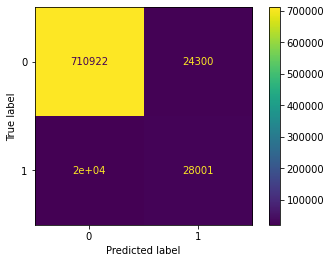

In [16]:
summarize(svm, train_embedded_X, train_dset_y)

## Cross-validation

In [17]:
from sklearn.model_selection import KFold



TRAINING:
F1 score: 0.5561379310344827
Precision: 0.5352818726369004
Recall: 0.5786850988587043
Confusion matrix:


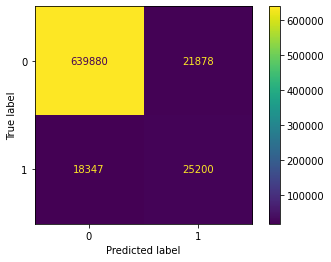


TESTING:
F1 score: 0.5533565390353058
Precision: 0.5400893030479519
Recall: 0.5672920065252854
Confusion matrix:


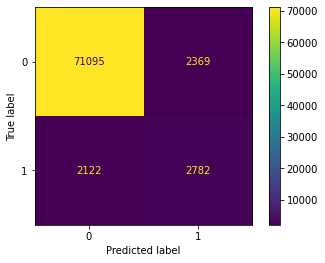



TRAINING:
F1 score: 0.5548657903457418
Precision: 0.534815382649802
Recall: 0.5764781491002571
Confusion matrix:


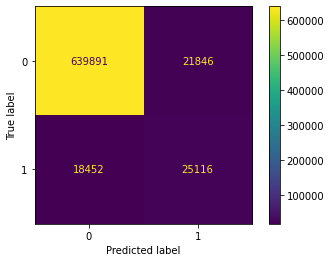


TESTING:
F1 score: 0.5639815088029901
Precision: 0.5425813777441333
Recall: 0.5871390538603317
Confusion matrix:


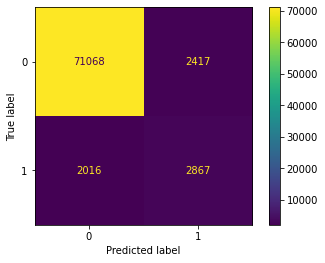



TRAINING:
F1 score: 0.5557945358084335
Precision: 0.5350847385634796
Recall: 0.5781719714528306
Confusion matrix:


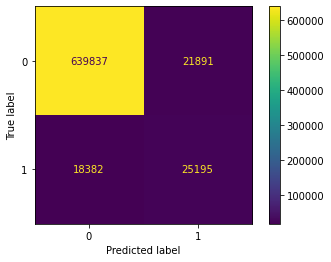


TESTING:
F1 score: 0.5604526503871351
Precision: 0.5428846153846154
Recall: 0.5791957324579401
Confusion matrix:


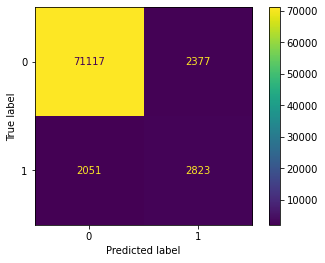



TRAINING:
F1 score: 0.5560463041490897
Precision: 0.5355369796749693
Recall: 0.578189064754793
Confusion matrix:


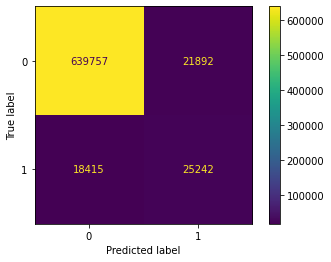


TESTING:
F1 score: 0.5541291822500759
Precision: 0.5375563836046283
Recall: 0.5717563621193158
Confusion matrix:


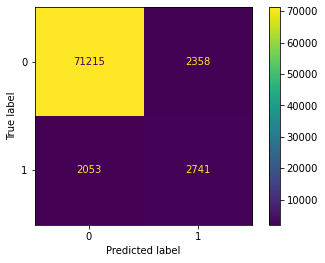



TRAINING:
F1 score: 0.555422177681354
Precision: 0.5351768925486534
Recall: 0.577259408479077
Confusion matrix:


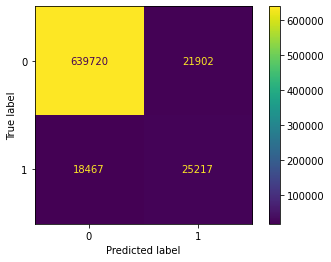


TESTING:
F1 score: 0.5567611010648985
Precision: 0.5342201657991131
Recall: 0.5812880218166562
Confusion matrix:


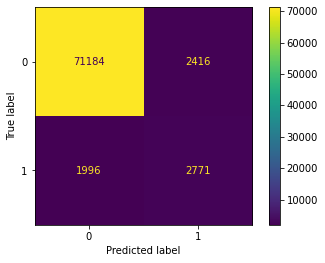



TRAINING:
F1 score: 0.5562381225968975
Precision: 0.5359165424739195
Recall: 0.57816160595342
Confusion matrix:


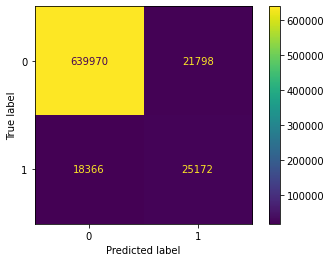


TESTING:
F1 score: 0.5536501714845664
Precision: 0.5338246409674982
Recall: 0.5750050885406065
Confusion matrix:


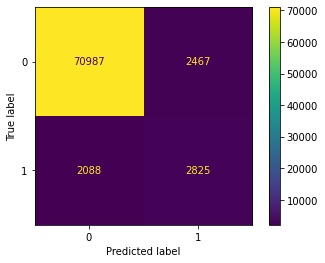

In [18]:
kfcv = KFold(n_splits=10, shuffle=True)
for train_indices, test_indices in kfcv.split(train_embedded_X):
    trainset_embedded_X = train_embedded_X[train_indices,:]
    trainset_y = train_dset_y[train_indices]
    testset_embedded_X = train_embedded_X[test_indices,:]
    testset_y = train_dset_y[test_indices]

    svm.fit(trainset_embedded_X, trainset_y)

    print("\n\nTRAINING:")
    summarize(svm, trainset_embedded_X, trainset_y)

    print("\nTESTING:")
    summarize(svm, testset_embedded_X, testset_y)


    

## Conclusion: Averaged embeddings with SVM saturate at F1 = 0.48

## Attempting Naive Bayes

In [15]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score, plot_confusion_matrix, precision_score, recall_score

In [45]:
gnb = GaussianNB(priors=(0.7, 0.3))

In [46]:
gnb.fit(train_embedded_X, train_dset_y)

GaussianNB(priors=(0.7, 0.3))

F1 score: 0.24627779799398297
Precision: 0.16381884878155215
Recall: 0.4958824379269778
Confusion matrix:


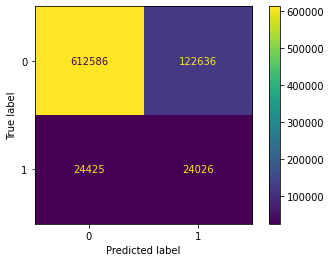

In [47]:
summarize(gnb, train_embedded_X, train_dset_y)

## Conclusion: Gaussian Naive Bayes on average embeddings saturates at training error 0.47

## Conclusion 2: Gaussian Naive Bayes is a bad fit for the summed embeddings

## SGDClassifier

In [9]:
from sklearn.linear_model import SGDClassifier

In [16]:
sgdc = SGDClassifier(loss="squared_hinge", max_iter=10000,class_weight={0:1,1:3.5}, tol=1E-4, n_iter_no_change=30)

In [17]:
sgdc.fit(train_embedded_X,train_dset_y)

SGDClassifier(class_weight={0: 1, 1: 3.5}, loss='squared_hinge', max_iter=10000,
              n_iter_no_change=30, tol=0.0001)

F1 score: 0.5558488455386669
Precision: 0.5298178008904186
Recall: 0.5845699779158325
Confusion matrix:


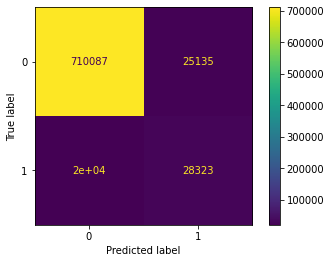

In [18]:
summarize(sgdc, train_embedded_X, train_dset_y)

## SGDC with cross-validation

In [19]:
from sklearn.model_selection import KFold



TRAINING:
F1 score: 0.553488952690051
Precision: 0.5481456507080242
Recall: 0.5589374527285645
Confusion matrix:


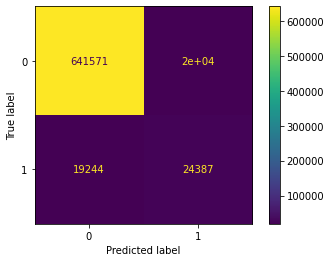


TESTING:
F1 score: 0.5512360242076111
Precision: 0.54514100223169
Recall: 0.5574688796680498
Confusion matrix:


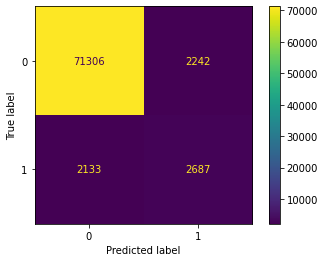

In [20]:
kfcv = KFold(n_splits=10, shuffle=True)
for train_indices, test_indices in kfcv.split(train_embedded_X):
    trainset_embedded_X = train_embedded_X[train_indices,:]
    trainset_y = train_dset_y[train_indices]
    testset_embedded_X = train_embedded_X[test_indices,:]
    testset_y = train_dset_y[test_indices]

    sgdc.fit(trainset_embedded_X, trainset_y)

    print("\n\nTRAINING:")
    summarize(sgdc, trainset_embedded_X, trainset_y)

    print("\nTESTING:")
    summarize(sgdc, testset_embedded_X, testset_y)

### Inference: SGD Classifier is a reliable algorithm for this task. Further, the SGD classifier exposes partial_fit which may be leveraged for concatenated word 

# Part 2: Concatenated embeddings

## Finding the cutoff for sentence length

In [48]:
train_dset_df["length"] = train_dset_df["preprocessed_joined"].progress_apply(lambda x: len(x.split(" ")))

100%|██████████| 783673/783673 [00:01<00:00, 724206.07it/s]


In [49]:
import seaborn as sns

<AxesSubplot:xlabel='length', ylabel='Count'>

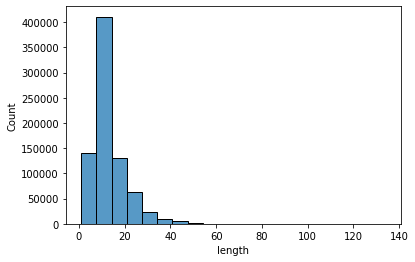

In [50]:
sns.histplot(train_dset_df["length"], bins=20)